In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt 
from math import floor              #функция округления в меньшую сторону

In [2]:
#функция индикатора I
def I(x):
    if x:
        return 1
    else:
        return 0

In [3]:
#функция поиска стационарных вероятностей
def find_Probs(X_all, lamb_u_c, lamb_u_r, lamb_m_c, lamb_m_r, mu_u_c, mu_u_r, mu_m_c, mu_m_r, teta_in_c, teta_in_r, teta_out_c):
    r = len(X_all)
    Mat = np.zeros((r, r))
    vector = np.zeros(r)
    for i in range(r):
        p = X_all[i]
        m_c, m_r, u_c, u_r = p
        Mat[i][i] = (-1) * (lamb_u_c * I(m_c + m_r + (u_c + 1) * d_c + u_r * d_r <= R) 
                            + lamb_u_r * I(m_c + m_r + u_c * d_c + (u_r + 1) * d_r <= R)
                            + u_c * mu_u_c * I(u_c > 0)
                            + u_r * mu_u_r * I(u_r > 0)
                            + teta_in_r * I(m_r == b_r) 
                            + mu_m_c * I(m_c != 0)
                            + mu_m_r * I(m_r == b_r)
                            + lamb_m_r * I(m_r == 0) * I(m_c + b_r + u_c * d_c + u_r * d_r <= R) 
                            + lamb_m_c * I(m_c == 0) * I(b_Los_c + m_r + u_c * d_c + u_r * d_r <= R) 
                            + teta_in_c * I(m_c == b_Los_c) 
                            + teta_out_c * I(m_c == b_nLos_c))
        #красные стрелки
        if m_c + m_r + (u_c + 1) * d_c + u_r * d_r <= R:
            ind = X_all.index([m_c, m_r, u_c + 1, u_r])
            Mat[i][ind] += (u_c + 1) * mu_u_c
        if u_c > 0:
            ind = X_all.index([m_c, m_r, u_c - 1, u_r])
            Mat[i][ind] += lamb_u_c 
        #оранжевые стрелки 
        if m_c + m_r + u_c * d_c + (u_r + 1) * d_r <= R:
            ind = X_all.index([m_c, m_r, u_c, u_r + 1])
            Mat[i][ind] += (u_r + 1) * mu_u_r
        if u_r > 0:
            ind = X_all.index([m_c, m_r, u_c, u_r - 1])
            Mat[i][ind] += lamb_u_r
        #синие стрелки  
        if m_r == 0 and m_c + b_r + u_c * d_c + u_r * d_r <= R:
            ind = X_all.index([m_c, b_r, u_c, u_r])
            Mat[i][ind] += teta_in_r
        #зеленые стрелки
        if m_r == b_r:
            ind = X_all.index([m_c, 0, u_c, u_r])
            Mat[i][ind] += lamb_m_r
        if m_r == 0 and m_c + b_r + u_c * d_c + u_r * d_r <= R:
            ind = X_all.index([m_c, b_r, u_c, u_r])
            Mat[i][ind] += mu_m_r
        #голубые стрелки
        if m_c ==b_Los_c:
            ind = X_all.index([0, m_r, u_c, u_r])
            Mat[i][ind] += lamb_m_c
        if m_c == 0 and b_Los_c + m_r + u_c * d_c + u_r * d_r <= R:
            ind = X_all.index([b_Los_c, m_r, u_c, u_r])
            Mat[i][ind] += mu_m_c
        if m_c == 0 and b_nLos_c + m_r + u_c * d_c + u_r * d_r <= R:
            ind = X_all.index([b_nLos_c, m_r, u_c, u_r])
            Mat[i][ind] += mu_m_c
        #фиолетовые стрелки
        if m_c == b_Los_c and b_nLos_c + m_r + u_c * d_c + u_r * d_r <= R:
            ind = X_all.index([b_nLos_c, m_r, u_c, u_r])
            Mat[i][ind] += teta_out_c
        if m_c == b_nLos_c:
            ind = X_all.index([b_Los_c, m_r, u_c, u_r])
            Mat[i][ind] += teta_in_c
        if m_c == b_nLos_c and  b_nLos_c + m_r + u_c * d_c + (u_r + 1) * d_r > R:
            if (R - b_Los_c - m_r - u_c * d_c - u_r * d_r) >= d_r:
                for k in range(1, floor((R - b_Los_c - m_r - u_c * d_c - u_r * d_r)/d_r) + 1):
                    ind = X_all.index([b_Los_c, m_r, u_c, u_r + k])
                    Mat[i][ind] += teta_in_c
        if m_c == b_nLos_c and u_r == 0 and b_nLos_c + m_r + (u_c + 1) * d_c > R:
            if (R - b_Los_c - m_r - u_c * d_c) >= d_c:
                for k in range(floor((R - b_Los_c - m_r - u_c * d_c)/d_r) + 1):
                    for p in range(1, floor((R - b_Los_c - m_r - u_c * d_c - k * d_r)/d_c) + 1):
                        ind = X_all.index([b_Los_c, m_r, u_c + p, k])
                        Mat[i][ind] += teta_in_c
    Mat[r-1] = [1 for i in range(r)]
    vector[r-1] = 1
    P_all = np.linalg.solve(Mat, vector)
    return P_all

In [4]:
def find_set(X_all):
    #множество состояний блокировки доступа запросов на установление многоадресных соединений в круге 
    B_M_c_arr_all = []  
    for i in X_all:
        m_c, m_r, u_c, u_r = i 
        if m_c == 0:
            if [b_Los_c, m_r, u_c, u_r] not in X_all:
                B_M_c_arr_all.append(i)
    #множество состояний блокировки доступа запросов на установление многоадресных соединений в кольце
    B_M_r_arr_all = []  
    for i in X_all:
        m_c, m_r, u_c, u_r = i 
        if m_r == 0:
            if [m_c, b_r, u_c, u_r] not in X_all:
                B_M_r_arr_all.append(i)
    #множество состояний блокировки доступа запросов на установление многоадресных соединений в системе 
    B_M_arr_all = B_M_c_arr_all.copy()
    for i in B_M_r_arr_all:
        if i not in B_M_arr_all:
            B_M_arr_all.append(i)
    B_M_arr_all.sort()   
    #множество состояний блокировки доступа запросов на установление однооадресных соединений в круге
    B_U_c_arr_all = []  
    for i in X_all:
        m_c, m_r, u_c, u_r = i 
        if [m_c, m_r, u_c + 1, u_r] not in X_all:
                B_U_c_arr_all.append(i)
    #множество состояний блокировки доступа запросов на установление однооадресных соединений в кольце
    B_U_r_arr_all = []  
    for i in X_all:
        m_c, m_r, u_c, u_r = i 
        if [m_c, m_r, u_c, u_r + 1] not in X_all:
                B_U_r_arr_all.append(i)
    #множество состояний блокировки доступа запросов на установление однооадресных соединений в системе 
    B_U_arr_all = B_U_c_arr_all.copy()
    for i in B_U_r_arr_all:
        if i not in B_U_arr_all:
            B_U_arr_all.append(i)
    B_U_arr_all.sort()
    #множество состояний прерывания обслуживания одноадресных соединений
    B_U_pr_all = []  
    for i in X_all:
        m_c, m_r, u_c, u_r = i 
        if m_c == b_Los_c:
            if [b_nLos_c, m_r, u_c, u_r] not in X_all:
                B_U_pr_all.append(i)
    #множества состояний прерывания обслуживания одноадресных соединений из кольца
    B_U_r_pr_all = []  
    for i in X_all:
        m_c, m_r, u_c, u_r = i 
        if m_c == b_Los_c:
            if [b_nLos_c, m_r, u_c, u_r] not in X_all:
                if u_r > 0:
                    B_U_r_pr_all.append(i)
    #множества состояний прерывания обслуживания одноадресных соединений из круга 
    B_U_c_pr_all = []  
    for i in X_all:
        m_c, m_r, u_c, u_r = i 
        if m_c == b_Los_c:
            if [b_nLos_c, m_r, u_c, 0] not in X_all:
                B_U_c_pr_all.append(i)
    #множество состояний прерывания обслуживания одноадресных соединений
    B_U_pr_all = []  
    for i in X_all:
        m_c, m_r, u_c, u_r = i 
        if m_c == b_Los_c:
            if [b_nLos_c, m_r, u_c, u_r] not in X_all:
                B_U_pr_all.append(i)
    #множество прерывания многоадресных соединений в кольце
    B_M_r_pr_all = []  
    for i in X_all:
        m_c, m_r, u_c, u_r = i
        if m_r == b_r:
            B_M_r_pr_all.append(i)
    #множество потери многоадресных соединений в системе 
    B_M_all = B_M_r_pr_all.copy()
    for i in B_M_arr_all:
        if i not in B_M_all:
            B_M_all.append(i)
    B_M_all.sort()
    #множество потери одноадресных соединений в системе 
    B_U_all = B_U_pr_all.copy()
    for i in B_U_arr_all:
        if i not in B_U_all:
            B_U_all.append(i)
    B_U_all.sort()
    return B_M_c_arr_all, B_M_r_arr_all, B_M_arr_all, B_U_c_arr_all, B_U_r_arr_all, B_U_arr_all, B_U_pr_all, B_U_r_pr_all, B_U_c_pr_all, B_M_r_pr_all, B_M_all, B_U_all

In [5]:
#функция поиска вероятностей
def find_probability(X_all, P_all, Set):
    Probability = 0
    for i in range(len(X_all)):
        if X_all[i] in Set:
            Probability += P_all[i]
    return Probability

In [6]:
#функция поиска занятого ресурса многоадресными, одноадресными и двумя соединениями
def find_Rs(X_all, P_all):
    #среднее число единиц ресурса, занятого одноадресными соединениями в круге
    R_U_c = 0
    for i in range(len(X_all)):
        m_c, m_r, u_c, u_r = X_all[i]
        if u_c != 0:
            R_U_c += P_all[i] * (u_c * d_c)
    #среднее число единиц ресурса, занятого одноадресными соединениями в кольце
    R_U_r = 0
    for i in range(len(X_all)):
        m_c, m_r, u_c, u_r = X_all[i]
        if u_r != 0:
            R_U_r += P_all[i] * (u_r * d_r)
    #среднее число единиц ресурса, занятого одноадресными соединениями
    R_U = 0
    for i in range(len(X_all)):
        m_c, m_r, u_c, u_r = X_all[i]
        R_U += P_all[i] * (u_c * d_c + u_r * d_r)
    #среднее число единиц ресурса, занятого многоадресными соединениями в круге
    R_M_c = 0
    for i in range(len(X_all)):
        m_c, m_r, u_c, u_r = X_all[i]
        if m_c != 0:
            R_M_c += P_all[i] * m_c
    #среднее число единиц ресурса, занятого многоадресными соединениями в кольце
    R_M_r = 0
    for i in range(len(X_all)):
        m_c, m_r, u_c, u_r = X_all[i]
        if m_r != 0:
            R_M_r += P_all[i] * m_r
    #среднее число единиц ресурса, занятого многоадресными соединениями
    R_M = 0
    for i in range(len(X_all)):
        m_c,m_r,u_c,u_r = X_all[i]
        R_M += P_all[i] * (m_c + m_r)
    #среднее число единиц занятого ресурса в системе
    R_ = 0
    for i in range(len(X_all)):
        m_c,m_r,u_c,u_r = X_all[i]
        R_ += P_all[i] * (m_c + m_r + u_c * d_c + u_r * d_r)
    return R_U_c, R_U_r, R_U, R_M_c, R_M_r, R_M, R_

In [7]:
#переменные ресурсов
R = 953.67 #ресурс системы
d_c = 33.47 #ресурс для обслуживания одноадресных заявок в круге
d_r = 90.37 #ресурс для обслуживания одноадресных заявок в кольце
b_Los_c = 137.7 #ресурс для обслуживания многоадресных заявок без блокировки в круге
b_nLos_c = 275.4 #ресурс для обслуживания заблокированных многоадресных заявок в круге 
b_r = 371.79 #ресурс для обслуживания многоадресных заявок без блокировки в кольце

In [8]:
#пространства состояний компонент СП
m_c_all = [0, b_Los_c, b_nLos_c]
m_r_all = [0, b_r]
u_c_all = [i for i in range(floor(R/d_c)+1)]
u_r_all = [i for i in range(floor(R/d_r)+1)]

In [9]:
#пространство состояний X
X_all = []
for m_c in m_c_all:
    for m_r in m_r_all:
        for u_c in u_c_all:
            for u_r in u_r_all:
                if m_c+m_r+u_c*d_c +u_r*d_r<=R:
                    X_all.append([m_c,m_r,u_c,u_r])

In [10]:
#множества потерь
B_M_c_arr_all, B_M_r_arr_all, B_M_arr_all, B_U_c_arr_all, B_U_r_arr_all, B_U_arr_all, B_U_pr_all, B_U_r_pr_all, B_U_c_pr_all, B_M_r_pr_all, B_M_all, B_U_all = find_set(X_all)

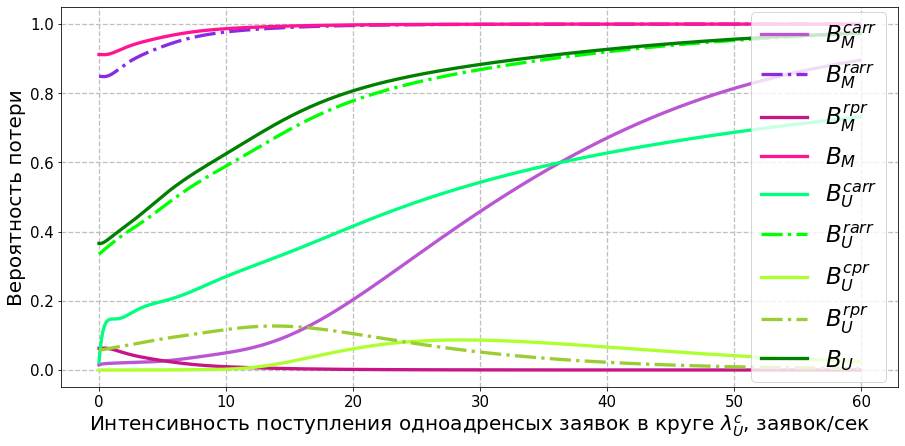

In [11]:
#Зависимость вероятности блокировки доступа запросов двух типов от интенсивности поступления одноадресных заявок в круге
lamb_u_r = 4 #интенстивность поступления одноадресных заявок в кольце
lamb_m_c = 6 #интенстивность поступления многоадресных заявок в круге
lamb_m_r = 3 #интенстивность поступления многоадресных заявок в кольце
mu_u_c = 0.6 #интенсивность обслуживания одноадресных заявок в круге
mu_u_r = 0.4 #интенсивность обслуживания одноадресных заявок в кольце
mu_m_c = 0.3 #интенсивность обслуживания многоадресных заявок в круге
mu_m_r = 0.2 #интенсивность обслуживания многоадресных заявок в круге
teta_in_c = 4 #интенсивность появления блокатора для многоадресного соединения в круге
teta_in_r = 4 #интенсивность появления блокатора для многоадресного соединения в кольце
teta_out_c = 1.25 #интенсивность ухода блокатора для многоадресного соединения в круге
P_M_c_arr = []
P_M_r_arr = []
P_M_arr = []
P_M_r_pr = []
P_M = []
P_U_c_arr = []
P_U_r_arr = []
P_U_arr = []
P_U_c_pr = []
P_U_r_pr = []
P_U_pr = []
P_U = []

LAMB_U_с = np.arange(0.01,60,0.1)
for i in LAMB_U_с:
    P_all = find_Probs(X_all, i , lamb_u_r, lamb_m_c, lamb_m_r, mu_u_c, mu_u_r, mu_m_c, mu_m_r, teta_in_c, teta_in_r, teta_out_c)
    P_M_c_arr.append(find_probability(X_all, P_all, B_M_c_arr_all))
    P_M_r_arr.append(find_probability(X_all, P_all, B_M_r_arr_all))
    P_M_arr.append(find_probability(X_all, P_all, B_M_arr_all))
    P_M_r_pr.append(find_probability(X_all, P_all, B_M_r_pr_all))
    P_M.append(find_probability(X_all, P_all, B_M_all))
    P_U_c_arr.append(find_probability(X_all, P_all, B_U_c_arr_all))
    P_U_r_arr.append(find_probability(X_all, P_all, B_U_r_arr_all))
    P_U_arr.append(find_probability(X_all, P_all, B_U_arr_all))
    P_U_c_pr.append(find_probability(X_all, P_all, B_U_c_pr_all))
    P_U_r_pr.append(find_probability(X_all, P_all, B_U_r_pr_all))
    P_U_pr.append(find_probability(X_all, P_all, B_U_pr_all))
    P_U.append(find_probability(X_all, P_all, B_U_all))

fig = plt.figure(figsize=(15,7))
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.xlabel('Интенсивность поступления одноадренсых заявок в круге $\lambda_{U}^{c}$, заявок/сек', color = 'black', size = 20)
plt.ylabel('Вероятность потери', color = 'black', size = 20)
plt.plot(LAMB_U_с, P_M_c_arr, label='$B_{M}^{c arr}$', c='mediumorchid', linewidth = 3.3)
plt.plot(LAMB_U_с, P_M_r_arr, label='$B_{M}^{r arr}$', c='blueviolet', linestyle = '-.', linewidth = 3.3)
plt.plot(LAMB_U_с, P_M_r_pr, label='$B_{M}^{r pr}$', c='mediumvioletred', linewidth = 3.3)
plt.plot(LAMB_U_с, P_M, label='$B_{M}$', c='deeppink', linewidth = 3.3)
plt.plot(LAMB_U_с, P_U_c_arr, label='$B_{U}^{c arr}$', c='springgreen', linewidth = 3.3)
plt.plot(LAMB_U_с, P_U_r_arr, label='$B_{U}^{r arr}$', c='lime', linestyle = '-.', linewidth = 3.3)
plt.plot(LAMB_U_с, P_U_c_pr, label='$B_{U}^{c pr}$', c='greenyellow', linewidth = 3.3)
plt.plot(LAMB_U_с, P_U_r_pr, label='$B_{U}^{r pr}$', c='yellowgreen', linestyle = '-.', linewidth = 3.3)
plt.plot(LAMB_U_с, P_U, label='$B_{U}$', c='green', linewidth = 3.3)
plt.legend(prop={'size': 23}, loc='center right')
plt.grid(color = 'silver',linestyle = '--', linewidth = 1.3)
#plt.show()
plt.savefig('Потеря при одноадресных в круге 1')

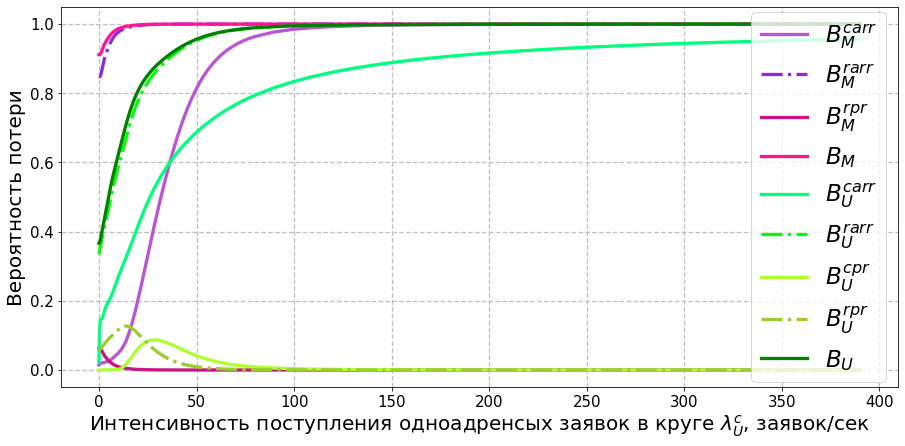

In [12]:
#Зависимость вероятности блокировки доступа запросов двух типов от интенсивности поступления одноадресных заявок в круге
lamb_u_r = 4 #интенстивность поступления одноадресных заявок в кольце
lamb_m_c = 6 #интенстивность поступления многоадресных заявок в круге
lamb_m_r = 3 #интенстивность поступления многоадресных заявок в кольце
mu_u_c = 0.6 #интенсивность обслуживания одноадресных заявок в круге
mu_u_r = 0.4 #интенсивность обслуживания одноадресных заявок в кольце
mu_m_c = 0.3 #интенсивность обслуживания многоадресных заявок в круге
mu_m_r = 0.2 #интенсивность обслуживания многоадресных заявок в круге
teta_in_c = 4 #интенсивность появления блокатора для многоадресного соединения в круге
teta_in_r = 4 #интенсивность появления блокатора для многоадресного соединения в кольце
teta_out_c = 1.25 #интенсивность ухода блокатора для многоадресного соединения в круге
P_M_c_arr = []
P_M_r_arr = []
P_M_arr = []
P_M_r_pr = []
P_M = []
P_U_c_arr = []
P_U_r_arr = []
P_U_arr = []
P_U_c_pr = []
P_U_r_pr = []
P_U_pr = []
P_U = []

LAMB_U_с = np.concatenate((np.arange(0.01,80,0.1),np.arange(80,400,10)))
for i in LAMB_U_с:
    P_all = find_Probs(X_all, i , lamb_u_r, lamb_m_c, lamb_m_r, mu_u_c, mu_u_r, mu_m_c, mu_m_r, teta_in_c, teta_in_r, teta_out_c)
    P_M_c_arr.append(find_probability(X_all, P_all, B_M_c_arr_all))
    P_M_r_arr.append(find_probability(X_all, P_all, B_M_r_arr_all))
    P_M_arr.append(find_probability(X_all, P_all, B_M_arr_all))
    P_M_r_pr.append(find_probability(X_all, P_all, B_M_r_pr_all))
    P_M.append(find_probability(X_all, P_all, B_M_all))
    P_U_c_arr.append(find_probability(X_all, P_all, B_U_c_arr_all))
    P_U_r_arr.append(find_probability(X_all, P_all, B_U_r_arr_all))
    P_U_arr.append(find_probability(X_all, P_all, B_U_arr_all))
    P_U_c_pr.append(find_probability(X_all, P_all, B_U_c_pr_all))
    P_U_r_pr.append(find_probability(X_all, P_all, B_U_r_pr_all))
    P_U_pr.append(find_probability(X_all, P_all, B_U_pr_all))
    P_U.append(find_probability(X_all, P_all, B_U_all))

fig = plt.figure(figsize=(15,7))
plt.xlabel('Интенсивность поступления одноадренсых заявок в круге $\lambda_{U}^{c}$, заявок/сек', color = 'black', size = 20)
plt.ylabel('Вероятность потери', color = 'black', size = 20)
plt.plot(LAMB_U_с, P_M_c_arr, label='$B_{M}^{c arr}$', c='mediumorchid', linewidth = 3.3)
plt.plot(LAMB_U_с, P_M_r_arr, label='$B_{M}^{r arr}$', c='blueviolet', linestyle = '-.', linewidth = 3.3)
plt.plot(LAMB_U_с, P_M_r_pr, label='$B_{M}^{r pr}$', c='mediumvioletred', linewidth = 3.3)
plt.plot(LAMB_U_с, P_M, label='$B_{M}$', c='deeppink', linewidth = 3.3)
plt.plot(LAMB_U_с, P_U_c_arr, label='$B_{U}^{c arr}$', c='springgreen', linewidth = 3.3)
plt.plot(LAMB_U_с, P_U_r_arr, label='$B_{U}^{r arr}$', c='lime', linestyle = '-.', linewidth = 3.3)
plt.plot(LAMB_U_с, P_U_c_pr, label='$B_{U}^{c pr}$', c='greenyellow', linewidth = 3.3)
plt.plot(LAMB_U_с, P_U_r_pr, label='$B_{U}^{r pr}$', c='yellowgreen', linestyle = '-.', linewidth = 3.3)
plt.plot(LAMB_U_с, P_U, label='$B_{U}$', c='green', linewidth = 3.3)
plt.legend(prop={'size': 23}, loc='center right')
plt.grid(color = 'silver',linestyle = '--', linewidth = 1.3)
#plt.show()
plt.savefig('Потеря при одноадресных в круге 2')

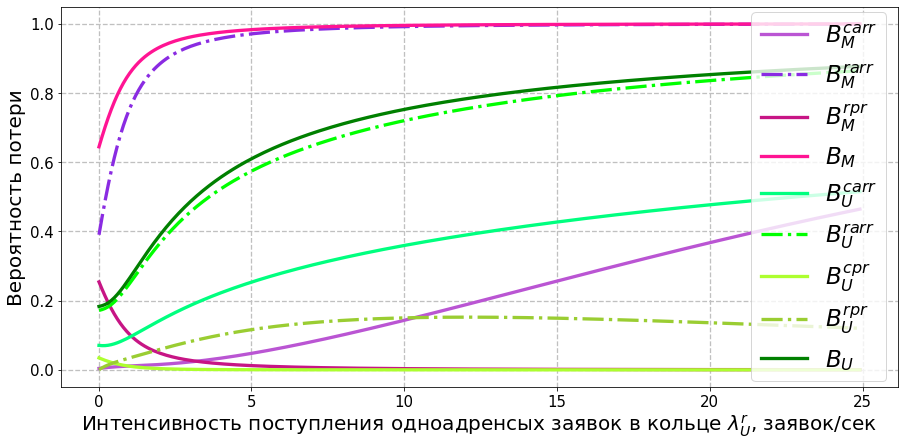

In [13]:
#Зависимость вероятности блокировки доступа запросов двух типов от интенсивности поступления одноадресных заявок в кольце
lamb_u_c = 7 #интенстивность поступления одноадресных заявок в круге
lamb_m_c = 6 #интенстивность поступления многоадресных заявок в круге 
lamb_m_r = 3 #интенстивность поступления многоадресных заявок в кольце
mu_u_c = 0.6 #интенсивность обслуживания одноадресных заявок в круге
mu_u_r = 0.4 #интенсивность обслуживания одноадресных заявок в кольце
mu_m_c = 0.3 #интенсивность обслуживания многоадресных заявок в круге
mu_m_r = 0.2 #интенсивность обслуживания многоадресных заявок в круге
teta_in_c = 4 #интенсивность появления блокатора для многоадресного соединения в круге
teta_in_r = 4 #интенсивность появления блокатора для многоадресного соединения в кольце
teta_out_c = 1.25 #интенсивность ухода блокатора для многоадресного соединения в круге
P_M_c_arr = []
P_M_r_arr = []
P_M_arr = []
P_M_r_pr = []
P_M = []
P_U_c_arr = []
P_U_r_arr = []
P_U_arr = []
P_U_c_pr = []
P_U_r_pr = []
P_U_pr = []
P_U = []

LAMB_U_r = np.arange(0.01,25,0.1)
for i in LAMB_U_r:
    P_all = find_Probs(X_all, lamb_u_c, i, lamb_m_c, lamb_m_r, mu_u_c, mu_u_r, mu_m_c, mu_m_r, teta_in_c, teta_in_r, teta_out_c)
    P_M_c_arr.append(find_probability(X_all, P_all, B_M_c_arr_all))
    P_M_r_arr.append(find_probability(X_all, P_all, B_M_r_arr_all))
    P_M_arr.append(find_probability(X_all, P_all, B_M_arr_all))
    P_M_r_pr.append(find_probability(X_all, P_all, B_M_r_pr_all))
    P_M.append(find_probability(X_all, P_all, B_M_all))
    P_U_c_arr.append(find_probability(X_all, P_all, B_U_c_arr_all))
    P_U_r_arr.append(find_probability(X_all, P_all, B_U_r_arr_all))
    P_U_arr.append(find_probability(X_all, P_all, B_U_arr_all))
    P_U_c_pr.append(find_probability(X_all, P_all, B_U_c_pr_all))
    P_U_r_pr.append(find_probability(X_all, P_all, B_U_r_pr_all))
    P_U_pr.append(find_probability(X_all, P_all, B_U_pr_all))
    P_U.append(find_probability(X_all, P_all, B_U_all))

fig = plt.figure(figsize=(15,7))
plt.xlabel('Интенсивность поступления одноадренсых заявок в кольце $\lambda_{U}^{r}$, заявок/сек', color = 'black', size = 20)
plt.ylabel('Вероятность потери', color = 'black', size = 20)
plt.plot(LAMB_U_r, P_M_c_arr, label='$B_{M}^{c arr}$', c='mediumorchid', linewidth = 3.3)
plt.plot(LAMB_U_r, P_M_r_arr, label='$B_{M}^{r arr}$', c='blueviolet', linestyle = '-.', linewidth = 3.3)
plt.plot(LAMB_U_r, P_M_r_pr, label='$B_{M}^{r pr}$', c='mediumvioletred', linewidth = 3.3)
plt.plot(LAMB_U_r, P_M, label='$B_{M}$', c='deeppink', linewidth = 3.3)
plt.plot(LAMB_U_r, P_U_c_arr, label='$B_{U}^{c arr}$', c='springgreen', linewidth = 3.3)
plt.plot(LAMB_U_r, P_U_r_arr, label='$B_{U}^{r arr}$', c='lime', linestyle = '-.',linewidth = 3.3)
plt.plot(LAMB_U_r, P_U_c_pr, label='$B_{U}^{c pr}$', c='greenyellow', linewidth = 3.3)
plt.plot(LAMB_U_r, P_U_r_pr, label='$B_{U}^{r pr}$', c='yellowgreen', linestyle = '-.', linewidth = 3.3)
plt.plot(LAMB_U_r, P_U, label='$B_{U}$', c='green', linewidth = 3.3)
plt.legend(prop={'size': 23}, loc='center right')
plt.grid(color = 'silver',linestyle = '--', linewidth = 1.3)
#plt.show()
plt.savefig('Потеря при одноадресных в кольце 1')

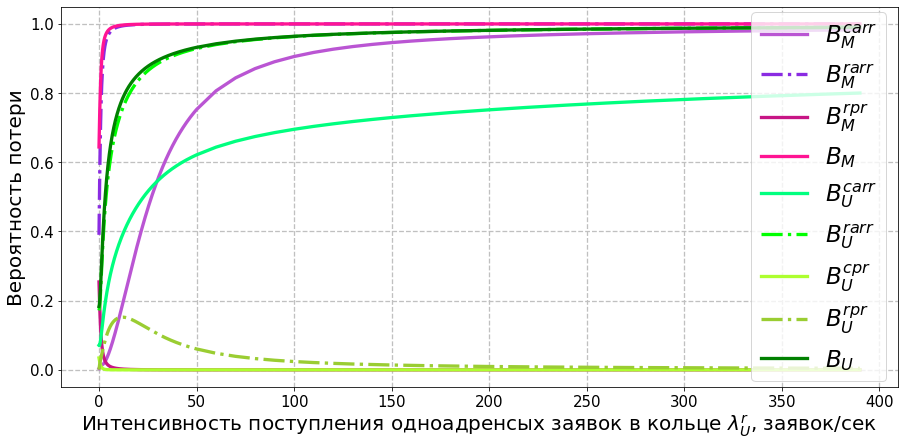

In [14]:
#Зависимость вероятности блокировки доступа запросов двух типов от интенсивности поступления одноадресных заявок в кольце
lamb_u_c = 7 #интенстивность поступления одноадресных заявок в круге
lamb_m_c = 6 #интенстивность поступления многоадресных заявок в круге 
lamb_m_r = 3 #интенстивность поступления многоадресных заявок в кольце
mu_u_c = 0.6 #интенсивность обслуживания одноадресных заявок в круге
mu_u_r = 0.4 #интенсивность обслуживания одноадресных заявок в кольце
mu_m_c = 0.3 #интенсивность обслуживания многоадресных заявок в круге
mu_m_r = 0.2 #интенсивность обслуживания многоадресных заявок в круге
teta_in_c = 4 #интенсивность появления блокатора для многоадресного соединения в круге
teta_in_r = 4 #интенсивность появления блокатора для многоадресного соединения в кольце
teta_out_c = 1.25 #интенсивность ухода блокатора для многоадресного соединения в круге
P_M_c_arr = []
P_M_r_arr = []
P_M_arr = []
P_M_r_pr = []
P_M = []
P_U_c_arr = []
P_U_r_arr = []
P_U_arr = []
P_U_c_pr = []
P_U_r_pr = []
P_U_pr = []
P_U = []

LAMB_U_r = np.concatenate((np.arange(0.01,50,0.1),np.arange(50,400,10)))
for i in LAMB_U_r:
    P_all = find_Probs(X_all, lamb_u_c, i, lamb_m_c, lamb_m_r, mu_u_c, mu_u_r, mu_m_c, mu_m_r, teta_in_c, teta_in_r, teta_out_c)
    P_M_c_arr.append(find_probability(X_all, P_all, B_M_c_arr_all))
    P_M_r_arr.append(find_probability(X_all, P_all, B_M_r_arr_all))
    P_M_arr.append(find_probability(X_all, P_all, B_M_arr_all))
    P_M_r_pr.append(find_probability(X_all, P_all, B_M_r_pr_all))
    P_M.append(find_probability(X_all, P_all, B_M_all))
    P_U_c_arr.append(find_probability(X_all, P_all, B_U_c_arr_all))
    P_U_r_arr.append(find_probability(X_all, P_all, B_U_r_arr_all))
    P_U_arr.append(find_probability(X_all, P_all, B_U_arr_all))
    P_U_c_pr.append(find_probability(X_all, P_all, B_U_c_pr_all))
    P_U_r_pr.append(find_probability(X_all, P_all, B_U_r_pr_all))
    P_U_pr.append(find_probability(X_all, P_all, B_U_pr_all))
    P_U.append(find_probability(X_all, P_all, B_U_all))

fig = plt.figure(figsize=(15,7))
plt.xlabel('Интенсивность поступления одноадренсых заявок в кольце $\lambda_{U}^{r}$, заявок/сек', color = 'black', size = 20)
plt.ylabel('Вероятность потери', color = 'black', size = 20)
plt.plot(LAMB_U_r, P_M_c_arr, label='$B_{M}^{c arr}$', c='mediumorchid', linewidth = 3.3)
plt.plot(LAMB_U_r, P_M_r_arr, label='$B_{M}^{r arr}$', c='blueviolet', linestyle = '-.', linewidth = 3.3)
plt.plot(LAMB_U_r, P_M_r_pr, label='$B_{M}^{r pr}$', c='mediumvioletred', linewidth = 3.3)
plt.plot(LAMB_U_r, P_M, label='$B_{M}$', c='deeppink', linewidth = 3.3)
plt.plot(LAMB_U_r, P_U_c_arr, label='$B_{U}^{c arr}$', c='springgreen', linewidth = 3.3)
plt.plot(LAMB_U_r, P_U_r_arr, label='$B_{U}^{r arr}$', c='lime', linestyle = '-.',linewidth = 3.3)
plt.plot(LAMB_U_r, P_U_c_pr, label='$B_{U}^{c pr}$', c='greenyellow', linewidth = 3.3)
plt.plot(LAMB_U_r, P_U_r_pr, label='$B_{U}^{r pr}$', c='yellowgreen', linestyle = '-.', linewidth = 3.3)
plt.plot(LAMB_U_r, P_U, label='$B_{U}$', c='green', linewidth = 3.3)
plt.legend(prop={'size': 23}, loc='center right')
plt.grid(color = 'silver',linestyle = '--', linewidth = 1.3)
#plt.show()
plt.savefig('Потеря при одноадресных в кольце 2')

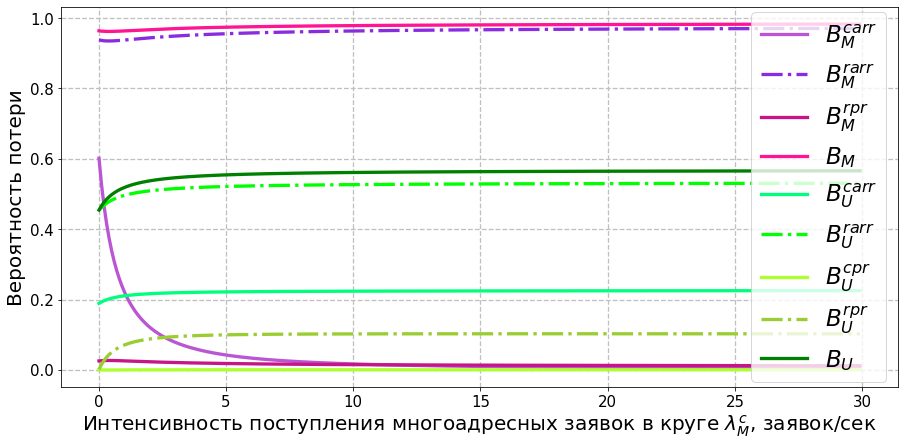

In [15]:
#Зависимость вероятности блокировки доступа запросов двух типов от интенсивности поступления многоадресных заявок в круге
lamb_u_c = 7 #интенстивность поступления одноадресных заявок в круге
lamb_u_r = 4 #интенстивность поступления одноадресных заявок в кольце
lamb_m_r = 3 #интенстивность поступления многоадресных заявок в кольце
mu_u_c = 0.6 #интенсивность обслуживания одноадресных заявок в круге
mu_u_r = 0.4 #интенсивность обслуживания одноадресных заявок в кольце
mu_m_c = 0.3 #интенсивность обслуживания многоадресных заявок в круге
mu_m_r = 0.2 #интенсивность обслуживания многоадресных заявок в круге
teta_in_c = 4 #интенсивность появления блокатора для многоадресного соединения в круге
teta_in_r = 4 #интенсивность появления блокатора для многоадресного соединения в кольце
teta_out_c = 1.25 #интенсивность ухода блокатора для многоадресного соединения в круге
P_M_c_arr = []
P_M_r_arr = []
P_M_arr = []
P_M_r_pr = []
P_M = []
P_U_c_arr = []
P_U_r_arr = []
P_U_arr = []
P_U_c_pr = []
P_U_r_pr = []
P_U_pr = []
P_U = []


LAMB_M_c = np.arange(0.01,30,0.1)
for i in LAMB_M_c:
    P_all = find_Probs(X_all, lamb_u_c, lamb_u_r, i, lamb_m_r, mu_u_c, mu_u_r, mu_m_c, mu_m_r, teta_in_c, teta_in_r, teta_out_c)
    P_M_c_arr.append(find_probability(X_all, P_all, B_M_c_arr_all))
    P_M_r_arr.append(find_probability(X_all, P_all, B_M_r_arr_all))
    P_M_arr.append(find_probability(X_all, P_all, B_M_arr_all))
    P_M_r_pr.append(find_probability(X_all, P_all, B_M_r_pr_all))
    P_M.append(find_probability(X_all, P_all, B_M_all))
    P_U_c_arr.append(find_probability(X_all, P_all, B_U_c_arr_all))
    P_U_r_arr.append(find_probability(X_all, P_all, B_U_r_arr_all))
    P_U_arr.append(find_probability(X_all, P_all, B_U_arr_all))
    P_U_c_pr.append(find_probability(X_all, P_all, B_U_c_pr_all))
    P_U_r_pr.append(find_probability(X_all, P_all, B_U_r_pr_all))
    P_U_pr.append(find_probability(X_all, P_all, B_U_pr_all))
    P_U.append(find_probability(X_all, P_all, B_U_all))
    
fig = plt.figure(figsize=(15,7))
plt.xlabel('Интенсивность поступления многоадресных заявок в круге $\lambda_{M}^{c}$, заявок/сек', color = 'black', size = 20)
plt.ylabel('Вероятность потери', color = 'black', size = 20)
plt.plot(LAMB_M_c, P_M_c_arr, label='$B_{M}^{c arr}$', c='mediumorchid', linewidth = 3.3)
plt.plot(LAMB_M_c, P_M_r_arr, label='$B_{M}^{r arr}$', c='blueviolet', linestyle = '-.', linewidth = 3.3)
plt.plot(LAMB_M_c, P_M_r_pr, label='$B_{M}^{r pr}$', c='mediumvioletred', linewidth = 3.3)
plt.plot(LAMB_M_c, P_M, label='$B_{M}$', c='deeppink', linewidth = 3.3)
plt.plot(LAMB_M_c, P_U_c_arr, label='$B_{U}^{c arr}$', c='springgreen', linewidth = 3.3)
plt.plot(LAMB_M_c, P_U_r_arr, label='$B_{U}^{r arr}$', c='lime', linestyle = '-.', linewidth = 3.3)
plt.plot(LAMB_M_c, P_U_c_pr, label='$B_{U}^{c pr}$', c='greenyellow', linewidth = 3.3)
plt.plot(LAMB_M_c, P_U_r_pr, label='$B_{U}^{r pr}$', c='yellowgreen', linestyle = '-.', linewidth = 3.3)
plt.plot(LAMB_M_c, P_U, label='$B_{U}$', c='green', linewidth = 3.3)
plt.legend(prop={'size': 23}, loc='center right')
plt.grid(color = 'silver',linestyle = '--', linewidth = 1.3)
#plt.show()
plt.savefig('Потеря при многоадресных в круге')

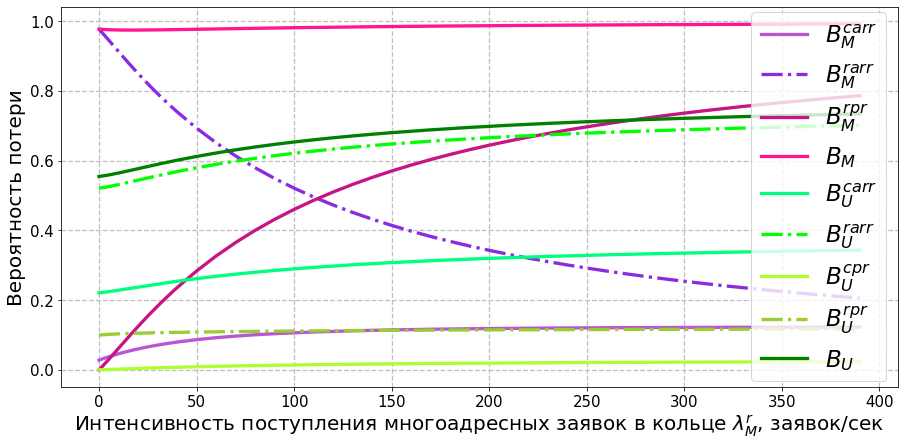

In [16]:
#Зависимость вероятности блокировки доступа запросов двух типов от интенсивности поступления многоадресных заявок в кольце
lamb_u_c = 7 #интенстивность поступления одноадресных заявок в круге
lamb_u_r = 4 #интенстивность поступления одноадресных заявок в кольце
lamb_m_c = 6 #интенстивность поступления многоадресных заявок в круге
mu_u_c = 0.6 #интенсивность обслуживания одноадресных заявок в круге
mu_u_r = 0.4 #интенсивность обслуживания одноадресных заявок в кольце
mu_m_c = 0.3 #интенсивность обслуживания многоадресных заявок в круге
mu_m_r = 0.2 #интенсивность обслуживания многоадресных заявок в круге
teta_in_c = 4 #интенсивность появления блокатора для многоадресного соединения в круге
teta_in_r = 4 #интенсивность появления блокатора для многоадресного соединения в кольце
teta_out_c = 1.25 #интенсивность ухода блокатора для многоадресного соединения в круге
P_M_c_arr = []
P_M_r_arr = []
P_M_arr = []
P_M_r_pr = []
P_M = []
P_U_c_arr = []
P_U_r_arr = []
P_U_arr = []
P_U_c_pr = []
P_U_r_pr = []
P_U_pr = []
P_U = []

LAMB_M_r = np.concatenate((np.arange(0.01,40,0.1),np.arange(40,400,10)))
for i in LAMB_M_r:
    P_all = find_Probs(X_all, lamb_u_c, lamb_u_r, lamb_m_c, i, mu_u_c, mu_u_r, mu_m_c, mu_m_r, teta_in_c, teta_in_r, teta_out_c)
    P_M_c_arr.append(find_probability(X_all, P_all, B_M_c_arr_all))
    P_M_r_arr.append(find_probability(X_all, P_all, B_M_r_arr_all))
    P_M_arr.append(find_probability(X_all, P_all, B_M_arr_all))
    P_M_r_pr.append(find_probability(X_all, P_all, B_M_r_pr_all))
    P_M.append(find_probability(X_all, P_all, B_M_all))
    P_U_c_arr.append(find_probability(X_all, P_all, B_U_c_arr_all))
    P_U_r_arr.append(find_probability(X_all, P_all, B_U_r_arr_all))
    P_U_arr.append(find_probability(X_all, P_all, B_U_arr_all))
    P_U_c_pr.append(find_probability(X_all, P_all, B_U_c_pr_all))
    P_U_r_pr.append(find_probability(X_all, P_all, B_U_r_pr_all))
    P_U_pr.append(find_probability(X_all, P_all, B_U_pr_all))
    P_U.append(find_probability(X_all, P_all, B_U_all))
    
fig = plt.figure(figsize=(15,7))
plt.xlabel('Интенсивность поступления многоадресных заявок в кольце $\lambda_{M}^{r}$, заявок/сек', color = 'black', size = 20)
plt.ylabel('Вероятность потери', color = 'black', size = 20)
plt.plot(LAMB_M_r, P_M_c_arr, label='$B_{M}^{c arr}$', c='mediumorchid', linewidth = 3.3)
plt.plot(LAMB_M_r, P_M_r_arr, label='$B_{M}^{r arr}$', c='blueviolet', linestyle = '-.', linewidth = 3.3)
plt.plot(LAMB_M_r, P_M_r_pr, label='$B_{M}^{r pr}$', c='mediumvioletred', linewidth = 3.3)
plt.plot(LAMB_M_r, P_M, label='$B_{M}$', c='deeppink', linewidth = 3.3)
plt.plot(LAMB_M_r, P_U_c_arr, label='$B_{U}^{c arr}$', c='springgreen', linewidth = 3.3)
plt.plot(LAMB_M_r, P_U_r_arr, label='$B_{U}^{r arr}$', c='lime', linestyle = '-.', linewidth = 3.3)
plt.plot(LAMB_M_r, P_U_c_pr, label='$B_{U}^{c pr}$', c='greenyellow', linewidth = 3.3)
plt.plot(LAMB_M_r, P_U_r_pr, label='$B_{U}^{r pr}$', c='yellowgreen', linestyle = '-.', linewidth = 3.3)
plt.plot(LAMB_M_r, P_U, label='$B_{U}$', c='green', linewidth = 3.3)
plt.legend(prop={'size': 23}, loc='center right')
plt.grid(color = 'silver',linestyle = '--', linewidth = 1.3)
#plt.show()
plt.savefig('Потеря при многоадресных в кольце')

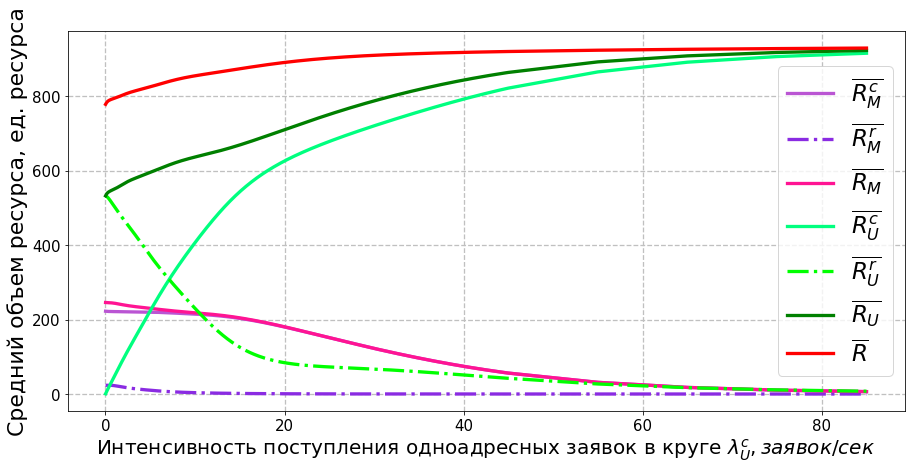

In [17]:
#Зависимость среднего объема используемого ресурса от создаваемой двумя типами трафика нагрузки.
lamb_u_r = 4 #интенстивность поступления одноадресных заявок в кольце
lamb_m_c = 6 #интенстивность поступления многоадресных заявок в круге
lamb_m_r = 3 #интенстивность поступления многоадресных заявок в кольце
mu_u_c = 0.6 #интенсивность обслуживания одноадресных заявок в круге
mu_u_r = 0.4 #интенсивность обслуживания одноадресных заявок в кольце
mu_m_c = 0.3 #интенсивность обслуживания многоадресных заявок в круге
mu_m_r = 0.2 #интенсивность обслуживания многоадресных заявок в круге
teta_in_c = 4 #интенсивность появления блокатора для многоадресного соединения в круге
teta_in_r = 4 #интенсивность появления блокатора для многоадресного соединения в кольце
teta_out_c = 1.25 #интенсивность ухода блокатора для многоадресного соединения в круге
R_Uuc_c = []
R_Uuc_r = []
R_Muc_c = []
R_Muc_r = []
R_Uuc = []
R_Muc = []
R_uc = []

LAMB_ = np.concatenate((np.arange(0.01,45,0.1),np.arange(45,90,10)))
for i in LAMB_:
    P_all = find_Probs(X_all, i , lamb_u_r, lamb_m_c, lamb_m_r, mu_u_c, mu_u_r, mu_m_c, mu_m_r, teta_in_c, teta_in_r, teta_out_c)
    r1,r2,r3,r4,r5,r6,r7 = find_Rs(X_all, P_all)
    R_Uuc_c.append(r1)
    R_Uuc_r.append(r2)
    R_Uuc.append(r3)
    R_Muc_c.append(r4)
    R_Muc_r.append(r5)
    R_Muc.append(r6)
    R_uc.append(r7)
    
fig = plt.figure(figsize=(15,7))

plt.xlabel('Интенсивность поступления одноадресных заявок в круге $\lambda_{U}^{c}, заявок/сек$', color = 'black', size = 20)
plt.ylabel('Средний объем ресурса, ед. ресурса', color = 'black', size = 22)    
plt.plot(LAMB_, R_Muc_c, label='$ \overline{R_{M}^{c}}$', c='mediumorchid', linewidth = 3.3)
plt.plot(LAMB_, R_Muc_r, label='$ \overline{R_{M}^{r}}$', c='blueviolet', linestyle = '-.', linewidth = 3.3)
plt.plot(LAMB_, R_Muc, label='$ \overline{R_{M}}$', c='deeppink', linewidth = 3.3)
plt.plot(LAMB_, R_Uuc_c, label='$ \overline{R_{U}^{c}}$', c='springgreen', linewidth = 3.3)
plt.plot(LAMB_, R_Uuc_r, label='$ \overline{R_{U}^{r}}$', c='lime', linestyle = '-.', linewidth = 3.3)
plt.plot(LAMB_, R_Uuc, label='$ \overline{R_{U}}$', c='green', linewidth = 3.3)
plt.plot(LAMB_, R_uc, label='$ \overline{R}$', c='r', linewidth = 3.3)
plt.legend(prop={'size': 23}, loc='center right')
plt.grid(color = 'silver',linestyle = '--', linewidth = 1.3)
#plt.show()
plt.savefig('Ресурс 1')

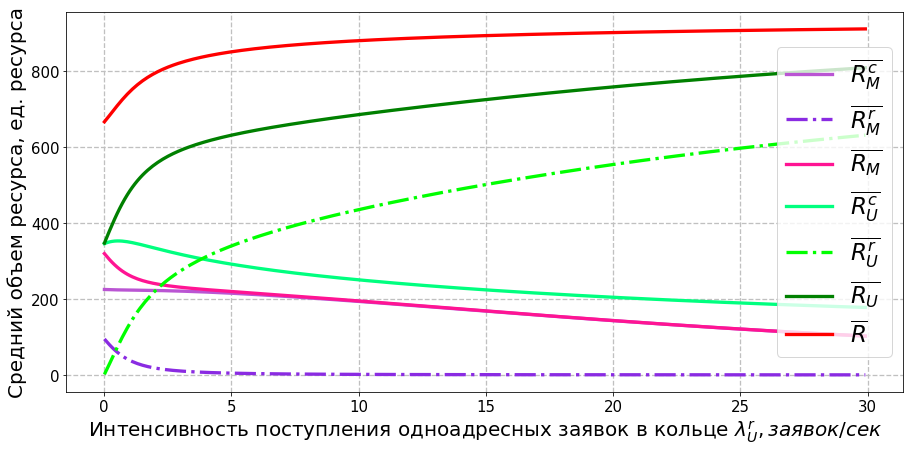

In [18]:
#Зависимость среднего объема используемого ресурса от создаваемой двумя типами трафика нагрузки.
lamb_u_c = 7 #интенстивность поступления одноадресных заявок в круге
lamb_m_c = 6 #интенстивность поступления многоадресных заявок в круге
lamb_m_r = 3 #интенстивность поступления многоадресных заявок в кольце
mu_u_c = 0.6 #интенсивность обслуживания одноадресных заявок в круге
mu_u_r = 0.4 #интенсивность обслуживания одноадресных заявок в кольце
mu_m_c = 0.3 #интенсивность обслуживания многоадресных заявок в круге
mu_m_r = 0.2 #интенсивность обслуживания многоадресных заявок в круге
teta_in_c = 4 #интенсивность появления блокатора для многоадресного соединения в круге
teta_in_r = 4 #интенсивность появления блокатора для многоадресного соединения в кольце
teta_out_c = 1.25 #интенсивность ухода блокатора для многоадресного соединения в круге
R_Uur_c = []
R_Uur_r = []
R_Mur_c = []
R_Mur_r = []
R_Uur = []
R_Mur = []
R_ur = []

LAMB_ = np.arange(0.01,30,0.1)
for i in LAMB_:
    P_all = find_Probs(X_all, lamb_u_c, i, lamb_m_c, lamb_m_r, mu_u_c, mu_u_r, mu_m_c, mu_m_r, teta_in_c, teta_in_r, teta_out_c)
    r1,r2,r3,r4,r5,r6,r7 = find_Rs(X_all, P_all)
    R_Uur_c.append(r1)
    R_Uur_r.append(r2)
    R_Uur.append(r3)
    R_Mur_c.append(r4)
    R_Mur_r.append(r5)
    R_Mur.append(r6)
    R_ur.append(r7)
    
fig = plt.figure(figsize=(15,7))
plt.xlabel('Интенсивность поступления одноадресных заявок в кольце $\lambda_{U}^{r}, заявок/сек$', color = 'black', size = 20)
plt.ylabel('Средний объем ресурса, ед. ресурса', color = 'black', size = 20)    
plt.plot(LAMB_, R_Mur_c, label='$ \overline{R_{M}^{c}}$', c='mediumorchid', linewidth = 3.3)
plt.plot(LAMB_, R_Mur_r, label='$ \overline{R_{M}^{r}}$', c='blueviolet', linestyle = '-.', linewidth = 3.3)
plt.plot(LAMB_, R_Mur, label='$ \overline{R_{M}}$', c='deeppink', linewidth = 3.3)
plt.plot(LAMB_, R_Uur_c, label='$ \overline{R_{U}^{c}}$', c='springgreen', linewidth = 3.3)
plt.plot(LAMB_, R_Uur_r, label='$ \overline{R_{U}^{r}}$', c='lime', linestyle = '-.', linewidth = 3.3)
plt.plot(LAMB_, R_Uur, label='$ \overline{R_{U}}$', c='green', linewidth = 3.3)
plt.plot(LAMB_, R_ur, label='$ \overline{R}$', c='r', linewidth = 3.3)
plt.legend(prop={'size': 23}, loc='center right')
plt.grid(color = 'silver',linestyle = '--', linewidth = 1.3)
#plt.show()
plt.savefig('Ресурс 2а')

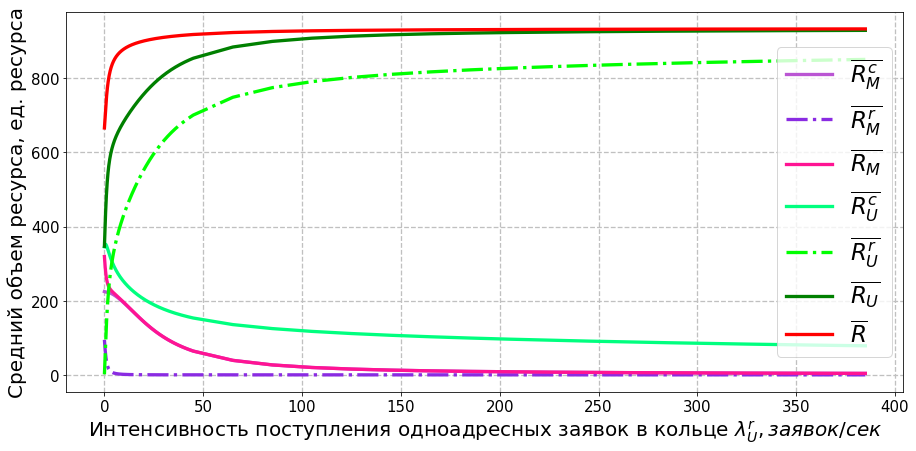

In [19]:
#Зависимость среднего объема используемого ресурса от создаваемой двумя типами трафика нагрузки.
lamb_u_c = 7 #интенстивность поступления одноадресных заявок в круге
lamb_m_c = 6 #интенстивность поступления многоадресных заявок в круге
lamb_m_r = 3 #интенстивность поступления многоадресных заявок в кольце
mu_u_c = 0.6 #интенсивность обслуживания одноадресных заявок в круге
mu_u_r = 0.4 #интенсивность обслуживания одноадресных заявок в кольце
mu_m_c = 0.3 #интенсивность обслуживания многоадресных заявок в круге
mu_m_r = 0.2 #интенсивность обслуживания многоадресных заявок в круге
teta_in_c = 4 #интенсивность появления блокатора для многоадресного соединения в круге
teta_in_r = 4 #интенсивность появления блокатора для многоадресного соединения в кольце
teta_out_c = 1.25 #интенсивность ухода блокатора для многоадресного соединения в круге
R_Uur_c = []
R_Uur_r = []
R_Mur_c = []
R_Mur_r = []
R_Uur = []
R_Mur = []
R_ur = []

LAMB_ = np.concatenate((np.arange(0.01,45,0.1),np.arange(45,400,20)))
for i in LAMB_:
    P_all = find_Probs(X_all, lamb_u_c, i, lamb_m_c, lamb_m_r, mu_u_c, mu_u_r, mu_m_c, mu_m_r, teta_in_c, teta_in_r, teta_out_c)
    r1,r2,r3,r4,r5,r6,r7 = find_Rs(X_all, P_all)
    R_Uur_c.append(r1)
    R_Uur_r.append(r2)
    R_Uur.append(r3)
    R_Mur_c.append(r4)
    R_Mur_r.append(r5)
    R_Mur.append(r6)
    R_ur.append(r7)
    
fig = plt.figure(figsize=(15,7))
plt.xlabel('Интенсивность поступления одноадресных заявок в кольце $\lambda_{U}^{r}, заявок/сек$', color = 'black', size = 20)
plt.ylabel('Средний объем ресурса, ед. ресурса', color = 'black', size = 20)    
plt.plot(LAMB_, R_Mur_c, label='$ \overline{R_{M}^{c}}$', c='mediumorchid', linewidth = 3.3)
plt.plot(LAMB_, R_Mur_r, label='$ \overline{R_{M}^{r}}$', c='blueviolet', linestyle = '-.', linewidth = 3.3)
plt.plot(LAMB_, R_Mur, label='$ \overline{R_{M}}$', c='deeppink', linewidth = 3.3)
plt.plot(LAMB_, R_Uur_c, label='$ \overline{R_{U}^{c}}$', c='springgreen', linewidth = 3.3)
plt.plot(LAMB_, R_Uur_r, label='$ \overline{R_{U}^{r}}$', c='lime', linestyle = '-.', linewidth = 3.3)
plt.plot(LAMB_, R_Uur, label='$ \overline{R_{U}}$', c='green', linewidth = 3.3)
plt.plot(LAMB_, R_ur, label='$ \overline{R}$', c='r', linewidth = 3.3)
plt.legend(prop={'size': 23}, loc='center right')
plt.grid(color = 'silver',linestyle = '--', linewidth = 1.3)
#plt.show()
plt.savefig('Ресурс 2б')

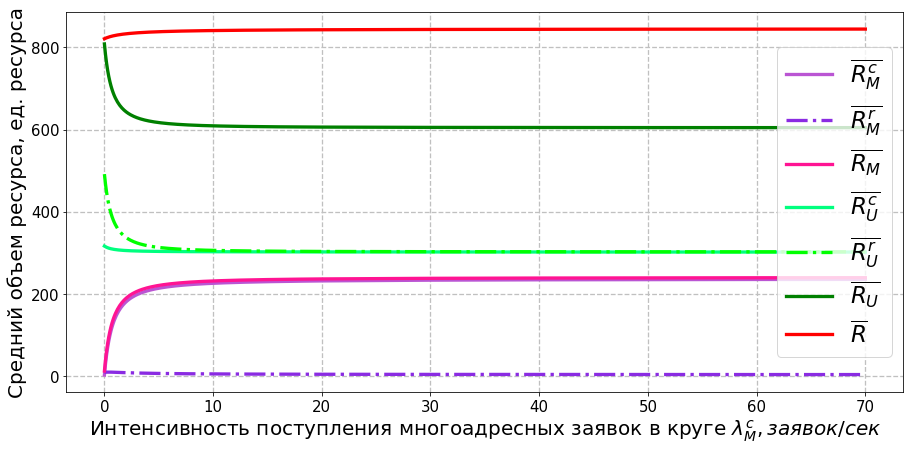

In [20]:
#Зависимость среднего объема используемого ресурса от создаваемой двумя типами трафика нагрузки.
lamb_u_c = 7 #интенстивность поступления одноадресных заявок в круге
lamb_u_r = 4 #интенстивность поступления одноадресных заявок в кольце
lamb_m_r = 3 #интенстивность поступления многоадресных заявок в кольце
mu_u_c = 0.6 #интенсивность обслуживания одноадресных заявок в круге
mu_u_r = 0.4 #интенсивность обслуживания одноадресных заявок в кольце
mu_m_c = 0.3 #интенсивность обслуживания многоадресных заявок в круге
mu_m_r = 0.2 #интенсивность обслуживания многоадресных заявок в круге
teta_in_c = 4 #интенсивность появления блокатора для многоадресного соединения в круге
teta_in_r = 4 #интенсивность появления блокатора для многоадресного соединения в кольце
teta_out_c = 1.25 #интенсивность ухода блокатора для многоадресного соединения в круге
R_Umc_c = []
R_Umc_r = []
R_Mmc_c = []
R_Mmc_r = []
R_Umc = []
R_Mmc = []
R_mc = []

LAMB_ = np.concatenate((np.arange(0.01,20,0.1),np.arange(20,80,10)))
for i in LAMB_:
    P_all = find_Probs(X_all, lamb_u_c, lamb_u_r, i, lamb_m_r, mu_u_c, mu_u_r, mu_m_c, mu_m_r, teta_in_c, teta_in_r, teta_out_c)
    r1,r2,r3,r4,r5,r6,r7 = find_Rs(X_all, P_all)
    R_Umc_c.append(r1)
    R_Umc_r.append(r2)
    R_Umc.append(r3)
    R_Mmc_c.append(r4)
    R_Mmc_r.append(r5)
    R_Mmc.append(r6)
    R_mc.append(r7)
    
fig = plt.figure(figsize=(15,7))
plt.xlabel('Интенсивность поступления многоадресных заявок в круге $\lambda_{M}^{c}, заявок/сек$', color = 'black', size = 20)
plt.ylabel('Средний объем ресурса, ед. ресурса', color = 'black', size = 20)    
plt.plot(LAMB_, R_Mmc_c, label='$ \overline{R_{M}^{c}}$', c='mediumorchid', linewidth = 3.3)
plt.plot(LAMB_, R_Mmc_r, label='$ \overline{R_{M}^{r}}$', c='blueviolet', linestyle = '-.', linewidth = 3.3)
plt.plot(LAMB_, R_Mmc, label='$ \overline{R_{M}}$', c='deeppink', linewidth = 3.3)
plt.plot(LAMB_, R_Umc_c, label='$ \overline{R_{U}^{c}}$', c='springgreen', linewidth = 3.3)
plt.plot(LAMB_, R_Umc_r, label='$ \overline{R_{U}^{r}}$', c='lime', linestyle = '-.', linewidth = 3.3)
plt.plot(LAMB_, R_Umc, label='$ \overline{R_{U}}$', c='green', linewidth = 3.3)
plt.plot(LAMB_, R_mc, label='$ \overline{R}$', c='r', linewidth = 3.3)
plt.legend(prop={'size': 23}, loc='center right')
plt.grid(color = 'silver',linestyle = '--', linewidth = 1.3)
#plt.show()
plt.savefig('Ресурс 3')

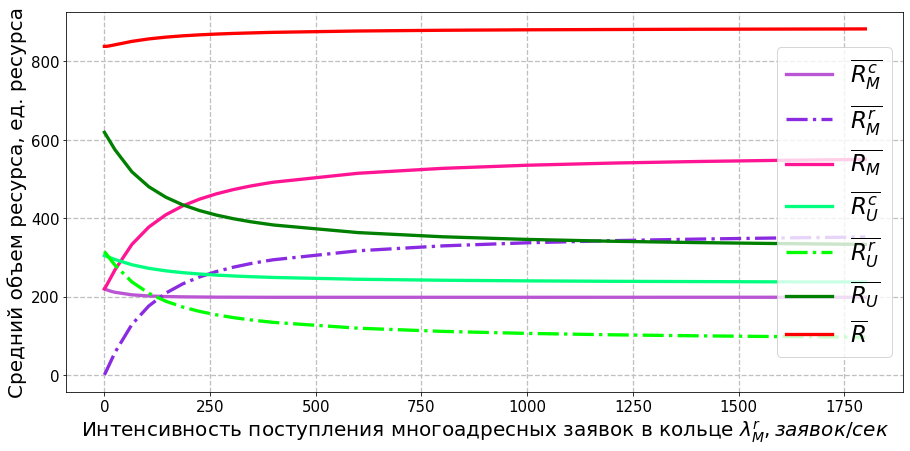

In [21]:
#Зависимость среднего объема используемого ресурса от создаваемой двумя типами трафика нагрузки.
lamb_u_c = 7 #интенстивность поступления одноадресных заявок в круге
lamb_u_r = 4 #интенстивность поступления одноадресных заявок в кольце
lamb_m_c = 6 #интенстивность поступления многоадресных заявок в круге
mu_u_c = 0.6 #интенсивность обслуживания одноадресных заявок в круге
mu_u_r = 0.4 #интенсивность обслуживания одноадресных заявок в кольце
mu_m_c = 0.3 #интенсивность обслуживания многоадресных заявок в круге
mu_m_r = 0.2 #интенсивность обслуживания многоадресных заявок в круге
teta_in_c = 4 #интенсивность появления блокатора для многоадресного соединения в круге
teta_in_r = 4 #интенсивность появления блокатора для многоадресного соединения в кольце
teta_out_c = 1.25 #интенсивность ухода блокатора для многоадресного соединения в круге
R_Umr_c = []
R_Umr_r = []
R_Mmr_c = []
R_Mmr_r = []
R_Umr = []
R_Mmr = []
R_mr = []

LAMB_ = np.concatenate((np.arange(0.01,25,0.1),np.arange(25,400,40)))
LAMB_ = np.concatenate((LAMB_ ,np.arange(400,2000,200)))
for i in LAMB_:
    P_all = find_Probs(X_all, lamb_u_c, lamb_u_r, lamb_m_c, i, mu_u_c, mu_u_r, mu_m_c, mu_m_r, teta_in_c, teta_in_r, teta_out_c)
    r1,r2,r3,r4,r5,r6,r7 = find_Rs(X_all, P_all)
    R_Umr_c.append(r1)
    R_Umr_r.append(r2)
    R_Umr.append(r3)
    R_Mmr_c.append(r4)
    R_Mmr_r.append(r5)
    R_Mmr.append(r6)
    R_mr.append(r7)
    
fig = plt.figure(figsize=(15,7))
plt.xlabel('Интенсивность поступления многоадресных заявок в кольце $\lambda_{M}^{r}, заявок/сек$', color = 'black', size = 20)
plt.ylabel('Средний объем ресурса, ед. ресурса', color = 'black', size = 20)    
plt.plot(LAMB_, R_Mmr_c, label='$ \overline{R_{M}^{c}}$', c='mediumorchid', linewidth = 3.3)
plt.plot(LAMB_, R_Mmr_r, label='$ \overline{R_{M}^{r}}$', c='blueviolet', linestyle = '-.', linewidth = 3.3)
plt.plot(LAMB_, R_Mmr, label='$ \overline{R_{M}}$', c='deeppink', linewidth = 3.3)
plt.plot(LAMB_, R_Umr_c, label='$ \overline{R_{U}^{c}}$', c='springgreen', linewidth = 3.3)
plt.plot(LAMB_, R_Umr_r, label='$ \overline{R_{U}^{r}}$', c='lime', linestyle = '-.', linewidth = 3.3)
plt.plot(LAMB_, R_Umr, label='$ \overline{R_{U}}$', c='green', linewidth = 3.3)
plt.plot(LAMB_, R_mr, label='$ \overline{R}$', c='r', linewidth = 3.3)
plt.legend(prop={'size': 23}, loc='center right')
plt.grid(color = 'silver',linestyle = '--', linewidth = 1.3)
#plt.show()
plt.savefig('Ресурс 4')